![link text](https://drive.google.com/uc?id=1ahpkkN2lfELpfDrmkVud9HlXJb3HAqhd)


## Goal

Optimizing the conversion rate is very important for business. It helps the business to grow their customer base, reduces the cost of advertising cacampaigns and as a result, generates more revenue. 

This project aims to predict the conversion rate by building a model, find out what kind of features have an impact on the conversion rate,and which segments perform good or bad. Based on the findings, I will provide insights for the marketing team. 

The data contains the demographic charateristics (eg: sex,age) and the browsing behaviours of the users. A user was considered "Converted" if end up buying something within a session, and vice versa. 

<br>
<br>

## Imports

In [2]:
mypath = '/content/drive/MyDrive/My_Project/Conversion_Rate'

In [5]:
import matplotlib
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, PrecisionRecallDisplay, f1_score
from sklearn.utils import compute_class_weight
from pdpbox import pdp, info_plots

from imblearn.over_sampling import SMOTE
sns.set_theme(rc={'figure.figsize':(11,8.27)},
              palette = 'Paired')

In [4]:
!pip3 install pdpbox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 34.0 MB 1.7 MB/s 
     |████████████████████████████████| 13.1 MB 26.6 MB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.1-py3-none-any.whl size=35758224 sha256=3cf8dd8b2ecf8905d90450e40a6dbaee311fbdbd8a4e7ae204819a912b921ede
  Stored in directory: /root/.cache/pip/wheels/f4/d0/1a/b80035625c53131f52906a6fc4dd690d8efd2bf8af6a4015eb
Successfully built pdpbox
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


<br>
<br>

## Load Data & Data Overview


**Data Descriptions**

<br>

* country : user country based on the IP address

* age : user age. Self-reported at sign-up step

* new_user : whether the user created the account during this session or had already an account and simply came back to the site

* source : marketing channel source
  * Ads: came to the site by clicking on an advertisement
  * Seo: came to the site by clicking on search results
  * Direct: came to the site by directly typing the URL on the browser

* total_pages_visited: number of total pages visited during the session. This can be seen as a proxy for time spent on site and engagement

* converted: this is our label. 1 means they converted within the session, 0 means they left without buying anything. The company goal is to increase conversion rate: # conversions / total sessions

<br>


In [6]:
data = pd.read_csv(mypath + '/data.csv')

In [7]:
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              316200 non-null  object
 1   age                  316200 non-null  int64 
 2   new_user             316200 non-null  int64 
 3   source               316200 non-null  object
 4   total_pages_visited  316200 non-null  int64 
 5   converted            316200 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


In [17]:
data.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


**A Few Quick Observations**

<br>

* The data set contains 316200 observations with no missing values.

* The conversion rate at ~3% is industry standard, which makes sense. 


* The user base is quite young with average age of 30.


* More than half of the users clcking the site have an account alreday. 

* Maximum age of 123 looks suspicious!! Let's look closer.

<br>

In [18]:
data.age.sort_values(ascending = False).unique()

array([123, 111,  79,  77,  73,  72,  70,  69,  68,  67,  66,  65,  64,
        63,  62,  61,  60,  59,  58,  57,  56,  55,  54,  53,  52,  51,
        50,  49,  48,  47,  46,  45,  44,  43,  42,  41,  40,  39,  38,
        37,  36,  35,  34,  33,  32,  31,  30,  29,  28,  27,  26,  25,
        24,  23,  22,  21,  20,  19,  18,  17])

As shown above, some users were above 110 years old. Very few people in the world live that long, let alone shop online. Let's find out who are those people.

<br>

In [19]:
data[data.age > 110]

,country,age,new_user,source,total_pages_visited,converted
90928,Germany,123,0,Seo,15,1
295581,UK,111,0,Ads,10,1


Only two users reported themselves as older than 110-year-old. These records are not so reliable, so just remove them. 

Now, let's dive deeper into the data and compare the distributions of the variables across two classes.

<br>
<br>


In [8]:
data = data.loc[data.age < 110]

## Exploratory Data Analysis 

**Q: Where are these users from? Who are the largest user base?** 




In [21]:
data.groupby('country').size().sort_values(ascending = False)

country
US         178092
China       76602
UK          48449
Germany     13055
dtype: int64

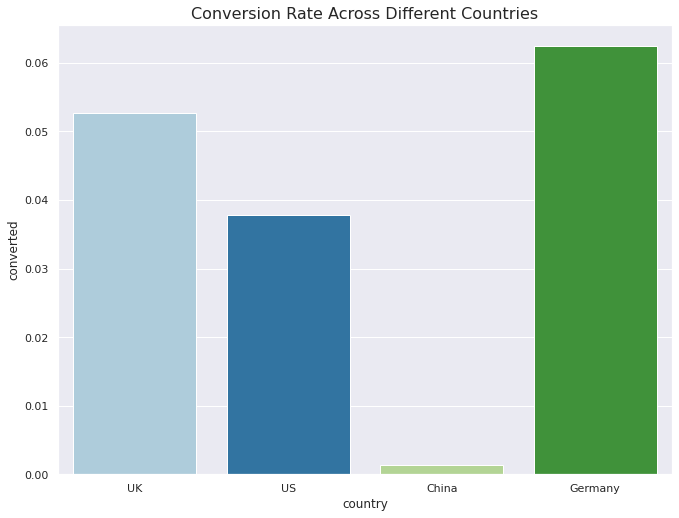

In [22]:
ax = sns.barplot(data = data,x = 'country',y = 'converted',
            ci = None,estimator = np.mean)
ax.set_title('Conversion Rate Across Different Countries',fontsize = 16);

* The users came from 4 different countries, mainly the US. This website is probably a US website.

* The plot shows that Germany has the highest conversion rate ~6% among all even though it has the least number of users. Then the UK comes after with ~5%. China, however, has extremely low conversion rate far less than 1%, which is abnormal.

<br>

**Q: How did the users come to the site? Which channel was most effective?** 



In [23]:
data.groupby('source').size().sort_values(ascending = False)

source
Seo       155039
Ads        88739
Direct     72420
dtype: int64

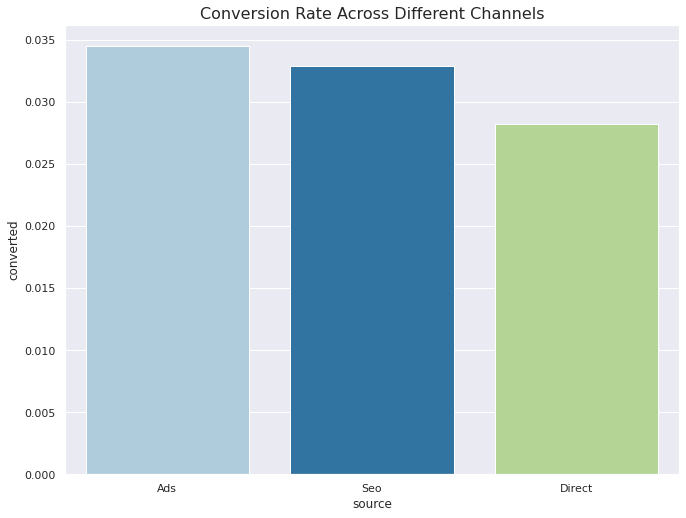

In [24]:
ax = sns.barplot(data = data,x = 'source',y = 'converted',
            ci = None,estimator = np.mean)
ax.set_title('Conversion Rate Across Different Channels',fontsize = 16);

Near a half of the users came to the site by clicking on search results. No strong association between the conversion hehavior and channel is shown, based on the plot.

<br>

**Q: How does the new users/ old users perfrom on different channel?**

In [25]:
data.groupby('new_user').size().sort_values(ascending = False)

new_user
1    216744
0     99454
dtype: int64

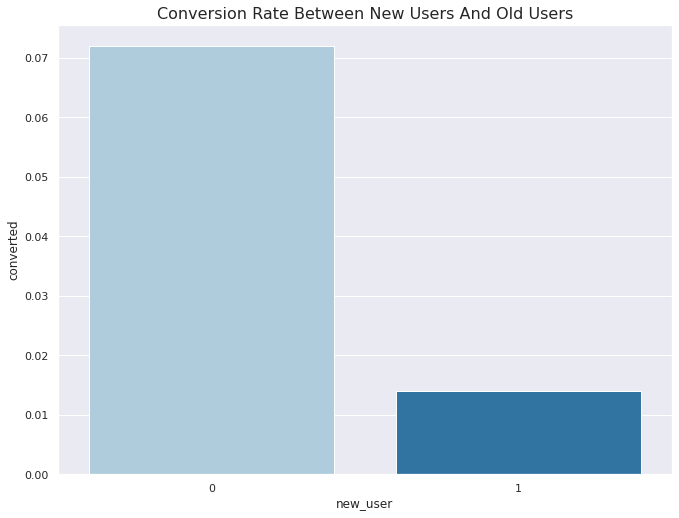

In [26]:
ax = sns.barplot(data = data,x = 'new_user',y = 'converted',
            ci = None,estimator = np.mean)
ax.set_title('Conversion Rate Between New Users And Old Users',fontsize = 16);

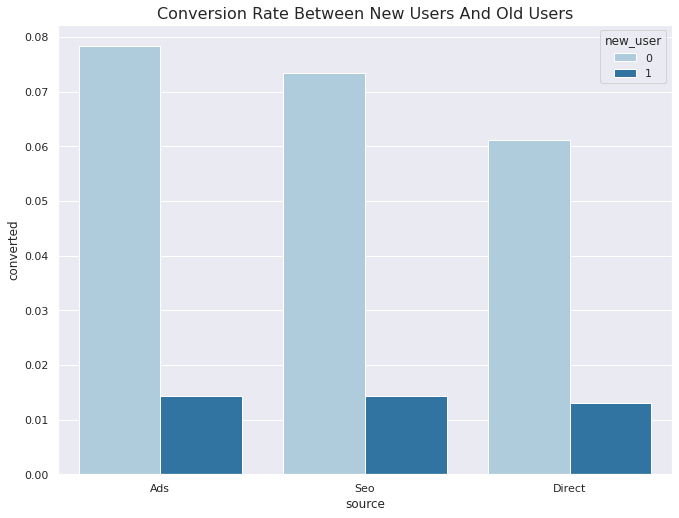

In [27]:
ax = sns.barplot(data = data,x = 'source',y = 'converted',hue = 'new_user',
            ci = None,estimator = np.mean)
ax.set_title('Conversion Rate Between New Users And Old Users',fontsize = 16);

 * No doubt old users converted at a much higher rate than new users.

 * New users performed nearly identically across channels. Which means, users barely made an purchase at the time they created an account regardless how they came to the site.

 * Interestingly, old users coming to the site by directly typing the URL typically had stronger purpose, but they converted at a lower rate than those attracted by ads 'at random'. Did the ads provide good offer or did the ads effectively promote the features of the product? 

 <br>

**Q: Is total pages visited associated with conversion rate?**

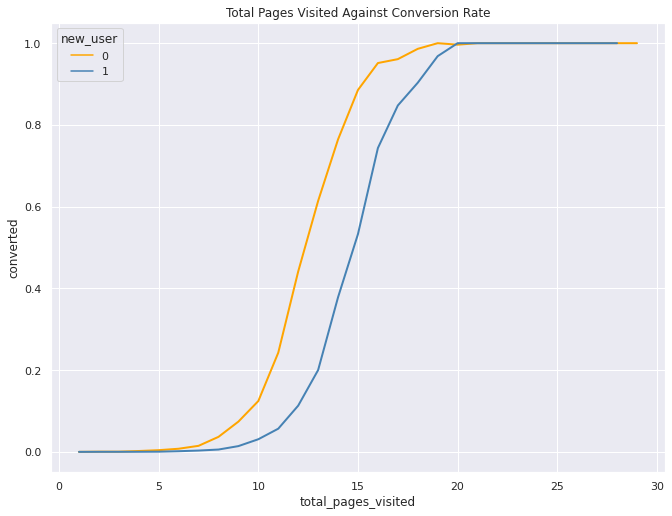

In [28]:
ax = sns.lineplot(data = data,y='converted', x='total_pages_visited',
                  estimator = 'mean', ci=None, hue='new_user',linewidth = 2,
                  palette = ['orange','steelblue'])
ax.set_title('Total Pages Visited Against Conversion Rate');

The plot indicated the number of pages visited in a session is positively associated with conversion rate. The conversion rate starts increasing rapidly after total pages visited of 10.

<br>


**Q:How many users converted and how many did not?**

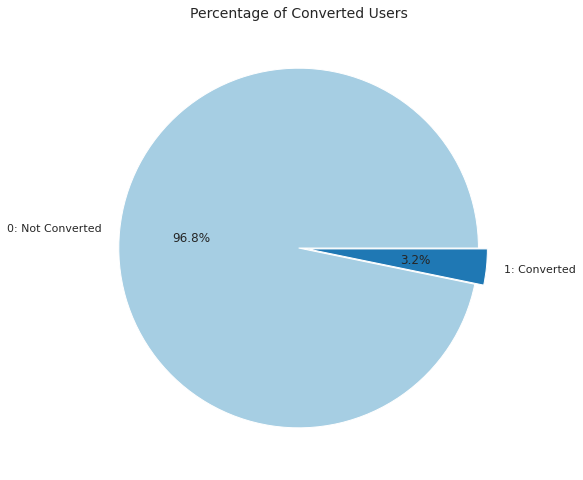

In [29]:
plt.pie(data.groupby('converted').size(), labels= ['0: Not Converted','1: Converted'],
        autopct='%.1f%%',explode = [0,0.05])
plt.title('Percentage of Converted Users',fontsize = 14);

As we can see, only ~3.2% users converted. The distribution is extremely unbalanced. 

<br>
<br>

## Modeling

Now,I am going to pick the random forest model to predict the conversion rate. Remind that our target variable 'converted' is a binary variable, so it is the problem of binary classification. The reasons I use random forest include:

1.   random forest is good at dealing with both discrete and continuous variables.
2.   it can identify the importance of the variables to the conversion rate.
3.   Typically, it performs very well on classification problems and prevent from overfitting with appropriate numbers of trees.

In addition, I am going to use F1 score to evaluate the performance of the model since F1 score handles imbalanced data very well. 

<br>



**Prepare the Data for Modeling**

In [9]:
# onehot encode the categorical variables
data = pd.get_dummies(data)
X = data.loc[:,data.columns != 'converted']
y = data.converted

In [10]:
#split the data into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25, 
                                                    random_state = 42,
                                                    stratify = y)

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size = 0.3, 
                                                    random_state = 42,
                                                    stratify = y)

**Create a Simple Raandom Forest Classifier**

In [32]:
# create a random forest classifier
clf = RandomForestClassifier(n_estimators = 100,n_jobs = -1,random_state = 42)
clf.fit(X_train,y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [51]:
y_train_pred = clf.predict(X_train)
print('The F1 socre on the training set is: ',np.round(f1_score(y_train, y_train_pred),3))

y_val_pred = clf.predict(X_val)
print('The F1 socre on the validaition set is: ', np.round(f1_score(y_val, y_val_pred),3))

The F1 socre on the training set is:  0.804
The F1 socre on the validaition set is:  0.735


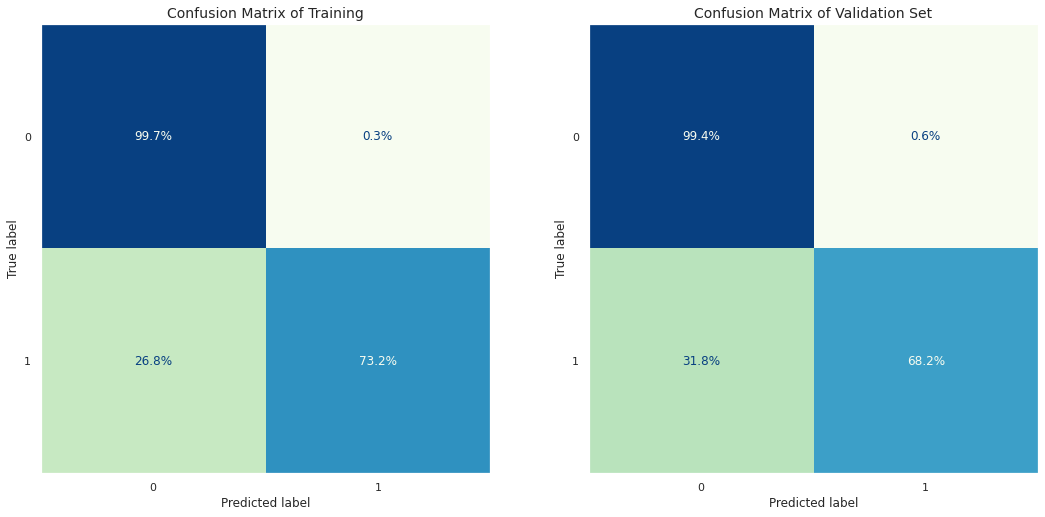

In [34]:
# plot confusion matrix
fig, axes = plt.subplots(1,2,figsize = (18,8.27))

ConfusionMatrixDisplay.from_predictions( y_train, y_train_pred, normalize = 'true',
                                      cmap = 'GnBu', colorbar = False,
                                      values_format = '.1%', ax = axes[0])
axes[0].set_title('Confusion Matrix of Training',fontsize = 14)
axes[0].grid(False)

ConfusionMatrixDisplay.from_predictions(y_val, y_val_pred, normalize = 'true',
                                      cmap = 'GnBu', colorbar = False,
                                      values_format = '.1%', ax = axes[1])
axes[1].set_title('Confusion Matrix of Validation Set',fontsize = 14)
axes[1].grid(False)


The F1 scores both the training set and validation set are quite decent, given 0.804 for the training and 0.735 for the validation set. But the gap between them still is still notable and could be smaller. Likewise, only 67.2% of the converted users were correctly classified.  

In order to address these issues, I will adjust the number of trees, the max depth of the trees and some other parameters to reduce the generalization variance. I will also increase the penalty of the misclassification of the converted class by increasing the weights of the converted class.

<br>

**Fine-tune the Parameters**

In [35]:
# compute the class weight
clss_wt = compute_class_weight(class_weight = 'balanced',classes = np.unique(y_train),
                               y = y_train)
class_wt = dict(zip(np.unique(y_train),clss_wt))

#parameter distribution
param_dist = {'n_estimators' : np.linspace(100,500,9,dtype = 'int'),
              'criterion': ['gini','entropy'],
              'max_depth': np.linspace(3,8,6,dtype = 'int'),
              'class_weight': [None,class_wt],
              'min_samples_split': np.linspace(2,6,5,dtype = 'int'),}

RSCV = RandomizedSearchCV(estimator=clf, 
                          param_distributions = param_dist,
                          n_iter = 20,
                          n_jobs = -1,
                          scoring = 'f1',
                          random_state = 0)

RSCV.fit(X_train,y_train)

RandomizedSearchCV(estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'class_weight': [None,
                                                         {0: 0.5166644101979935,
                                                          1: 15.502031096792267}],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': array([3, 4, 5, 6, 7, 8]),
                                        'min_samples_split': array([2, 3, 4, 5, 6]),
                                        'n_estimators': array([100, 150, 200, 250, 300, 350, 400, 450, 500])},
                   random_state=0, scoring='f1')

In [50]:
# best mean_test_score
print('The best mean validation score of CV is ',np.round(RSCV.best_score_,3),'\n')

# best parameters
print('The best parameters of CV is \n',
      RSCV.best_params_)

The best mean validation score of CV is  0.757 

The best parameters of CV is 
 {'n_estimators': 500, 'min_samples_split': 5, 'max_depth': 8, 'criterion': 'entropy', 'class_weight': None}


**Model Evaluation on the Training and Validation Set**

In [37]:
# refit our best model on the training set 
best_params = RSCV.best_params_
best_clf = RandomForestClassifier(random_state = 42,n_jobs = -1)
best_clf.set_params(**best_params)
best_clf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=8, min_samples_split=5,
                       n_estimators=500, n_jobs=-1, random_state=42)

In [47]:
y_train_pred = best_clf.predict(X_train)
print('The F1 socre on the training set is: ',np.round(f1_score(y_train, y_train_pred),3))

y_val_pred = best_clf.predict(X_val)
print('The F1 socre on the validaition set is: ', np.round(f1_score(y_val, y_val_pred),3))

The F1 socre on the training set is:  0.764
The F1 socre on the validaition set is:  0.761


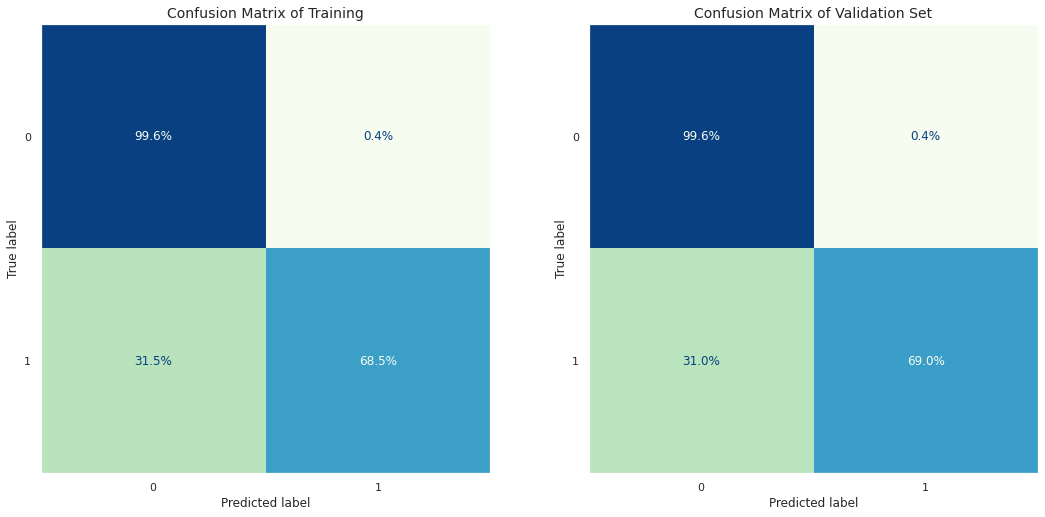

In [39]:
fig, axes = plt.subplots(1,2,figsize = (18,8.27))

ConfusionMatrixDisplay.from_predictions( y_train, y_train_pred, normalize = 'true',
                                      cmap = 'GnBu', colorbar = False,
                                      values_format = '.1%', ax = axes[0])
axes[0].set_title('Confusion Matrix of Training',fontsize = 14)
axes[0].grid(False)

ConfusionMatrixDisplay.from_predictions(y_val, y_val_pred, normalize = 'true',
                                      cmap = 'GnBu', colorbar = False,
                                      values_format = '.1%', ax = axes[1])
axes[1].set_title('Confusion Matrix of Validation Set',fontsize = 14)
axes[1].grid(False)

The gap between the training and validation F1 scores has reduced significantly, given 0.764 and 0.761 respectively (compared to the previous 0.804 and 0.735). There is also a slight improvement in the validation set.
The performance of our fine-tuned model is much more stable and reliable compared to the original model. 


<br>


In [2]:
# Oversampling&Undersampling

# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import TomekLinks

# over = SMOTE(sampling_strategy = {1:14000},random_state = 42)
# #under = TomekLinks(sampling_strategy = 'auto')
# X_train_res,y_train_res = over.fit_resample(X_train,y_train)
# #X_train_res,y_train_res = under.fit_resample(X_train_res,y_train_res)


# best_clf.fit(X_train_res,y_train_res)
# y_train_pred = best_clf.predict(X_train)
# print('The F1 socre on the training set is: ',np.round(f1_score(y_train, y_train_pred),2))

# y_val_pred = best_clf.predict(X_val)
# print('The F1 socre on the validaition set is: ', np.round(f1_score(y_val, y_val_pred),2))

**Model Evaluation on the Test Set**

In [48]:
y_test_pred = best_clf.predict(X_test)
print('The F1 socre on the test set is: ',np.round(f1_score(y_test, y_test_pred),3))

The F1 socre on the test set is:  0.753


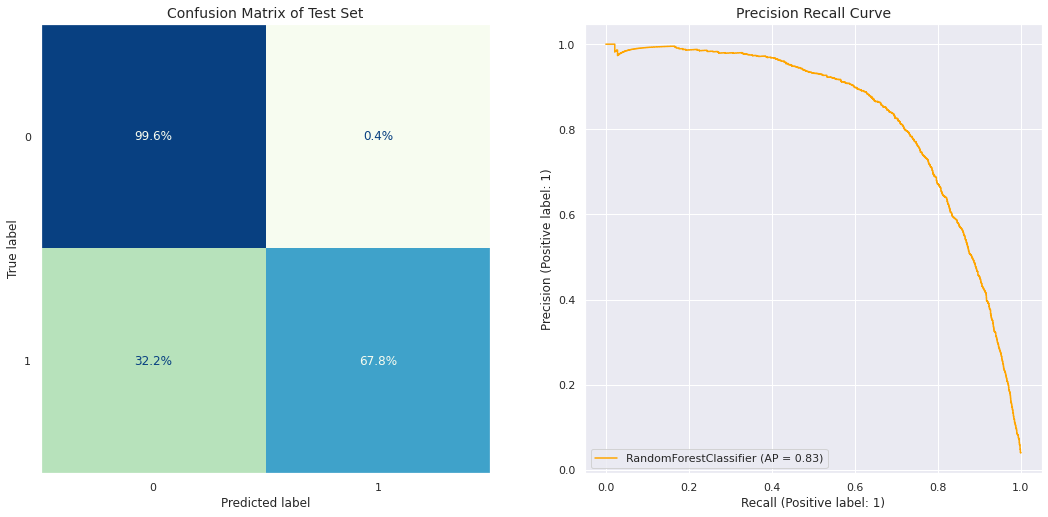

In [42]:
fig, axes = plt.subplots(1,2,figsize = (18,8.27))

# plot the confusion matrix of the test set
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, normalize = 'true',
                                      cmap = 'GnBu', colorbar = False,
                                      values_format = '.1%', ax = axes[0])
axes[0].set_title('Confusion Matrix of Test Set',fontsize = 14)
axes[0].grid(False)

# plot Precision-Recall curve
PrecisionRecallDisplay.from_estimator(estimator = best_clf, X = X_test, y = y_test,
                                      color = 'orange',ax = axes[1])
axes[1].set_title('Precision Recall Curve',fontsize = 14);

As we expected, the model performed stably on the unseen data. The F1 score on the test set is still 0.76, same as the validation score and only 0.1 less than the training score. 

The Precision-Recall curve describes the trade-off between precision and recall across different thresholds, so the larger area under the curve (up to 1) the better performance of the model. The curve shows our model performs really good too.

<br>

**Feature Importance**

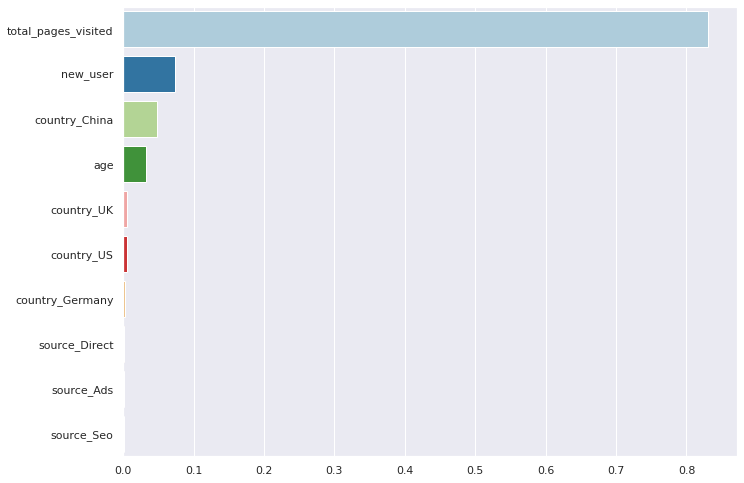

In [44]:
feature_importances = best_clf.feature_importances_
rank_feature_importances = np.argsort(feature_importances)
sns.barplot(y = best_clf.feature_names_in_[rank_feature_importances][::-1],
            x = np.sort(feature_importances)[::-1]);

* The total number of pages visited is most important according to our model.
Unfortunately, this feature is the least actionable. Because when users are ready to buy something, they typically visit more pages, such as reading the descriptions of the product, comparing prices between products. Also, purchasing a product requires users to access more pages to finish payment. 

* Source related feature seems not so important to the conversion.

<br>

**Partical Dependence Plot**


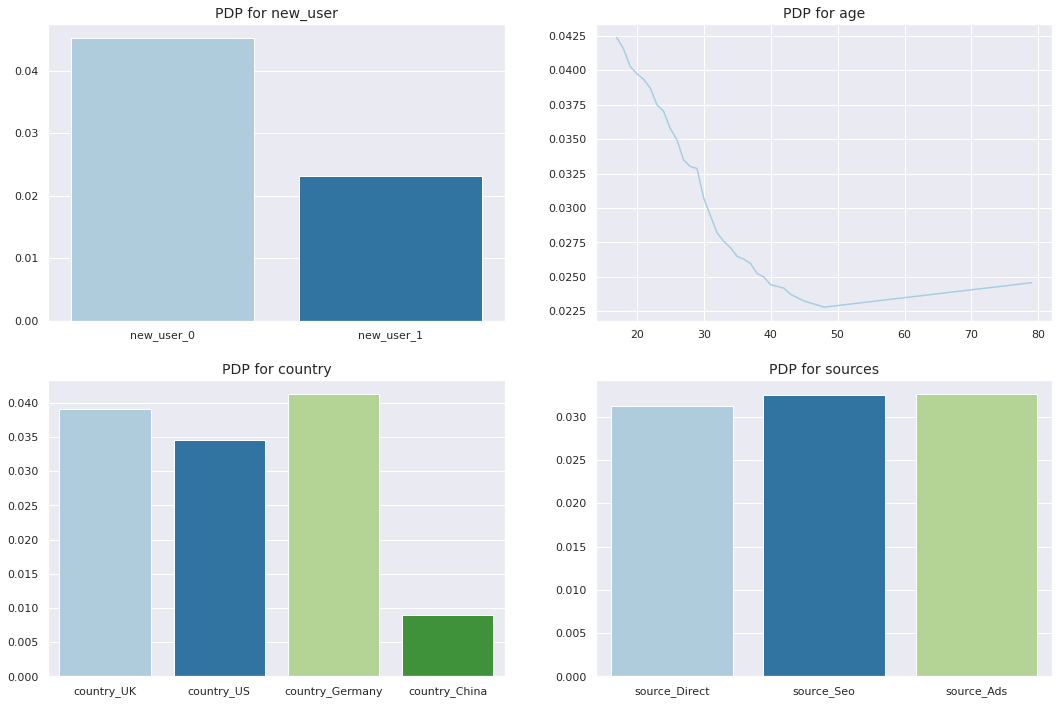

In [15]:
fig,axes = plt.subplots(2,2,figsize = (18,12))

#pdp for new_user
pdp_iso_nu = pdp.pdp_isolate(model = best_clf, dataset = X_train, 
                          model_features = X_train.columns,feature = 'new_user',
                          num_grid_points= 40, n_jobs = -1)

sns.barplot(x = pdp_iso_nu.display_columns, y = pdp_iso_nu.pdp, ax = axes[0,0])
axes[0,0].set_title('PDP for new_user', fontsize = 14)

#pdp for age
pdp_iso_age = pdp.pdp_isolate(model = best_clf, dataset = X_train, 
                          model_features = X_train.columns,feature = 'age',
                          num_grid_points= 40, n_jobs = -1)

sns.lineplot(x = pdp_iso_age.feature_grids, y = pdp_iso_age.pdp, ax = axes[0,1])
axes[0,1].set_title('PDP for age', fontsize = 14)

#pdp for country
pdp_iso_cty = pdp.pdp_isolate(model = best_clf, dataset = X_train, 
                          model_features = X_train.columns,
                          feature = ['country_UK','country_US','country_Germany','country_China'],
                          num_grid_points= 40, n_jobs = -1)

sns.barplot(x = pdp_iso_cty.display_columns, y = pdp_iso_cty.pdp, ax = axes[1,0])
axes[1,0].set_title('PDP for country', fontsize = 14)


#pdp for sources
pdp_iso_soc = pdp.pdp_isolate(model = best_clf, dataset = X_train, 
                          model_features = X_train.columns,
                          feature = ['source_Direct','source_Seo','source_Ads'],
                          num_grid_points= 40, n_jobs = -1)

sns.barplot(x = pdp_iso_soc.display_columns, y = pdp_iso_soc.pdp, ax = axes[1,1])
axes[1,1].set_title('PDP for sources', fontsize = 14);


* Users with account came back to site are more likely to convert.
* Users under 30 years old did very well.
* UK,US and Gernmany have similar marginal impact on the conversion, with the Gernmany being the best. They all have high values, compared with China. In other words, China has very bas conversion.
* Whichever source the users use did not matter much on the conversion.

<br>
Now let's build a simple decision tree without the total_pages_visited and find out the most important segments.

<br>

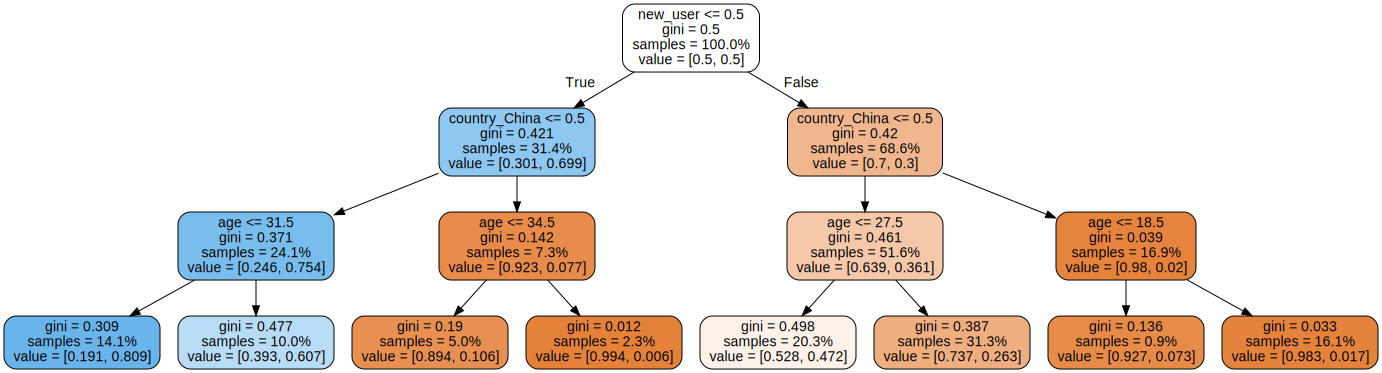

In [87]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from pydotplus import graph_from_dot_data
from graphviz import Source

tree_clf = DecisionTreeClassifier(max_depth= 3,random_state= 42,class_weight = class_wt)
tree_clf.fit(X_train.loc[:, X_train.columns != 'total_pages_visited'],y_train)


dot_data = export_graphviz(tree_clf, out_file= None, 
                           feature_names= X_train.columns[X_train.columns != 'total_pages_visited'],
                           proportion=True,
                           rounded = True,
                           filled = True)


gvz_graph = Source(dot_data)
gvz_graph

The simple decision tree has an agreement with the random forest on the most important segments. 

##Conclusion

* Users with old accounts do much better in terms of conversion, so targeted emails with offers or promotions to bring them back to the site could be a good strategy to try.

* German perfroms the best among all countries. However, the total number of germany users coming to the site is the least despite a much larger population than UK. Attracting more German or improve the product awareness in German can potentially generate more values. 

* Users oder than 30 years old perfrom poorly. Does this caused by the flawless of user interface or comlexity of operations? A good actionable metric here is the conversion rate for users older than 30 years old. Is that possible to build a team foucusing on increasing this metirc?

* Even though lots of Chinese people visited the site, the conversion rate is extremely low. There could be something wrong with the Chinese Version of the site. Does it asscoiated with poor translation, poor culture fit, or payment issues? Investigating these problems and fixing them could bring huge value to the company based on the tremendous user base in China.